In [2]:
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import pandas as pd
import time
import numpy as np


### Import and Combine data1.csv , data2.xlsx

In [3]:
raw_data_2 = pd.ExcelFile('../../Data/data2.xlsx')
# raw_data_2.sheet_names : ['1', '2', '3', '4', '5', '6', '7', '8', 'Sheet1']
dfs = {sheet: raw_data_2.parse(sheet) for sheet in raw_data_2.sheet_names}

data1 = dfs['7']
data2 = dfs['1'].loc[:,['Patient','Age at Diagnosis']].drop([554]).drop_duplicates()

raw_data_1 = pd.read_csv('../../Data/data1.csv')
combined_data = (data1.set_index('Patient').join(data2.set_index('Patient'))
                 .join(raw_data_1.set_index('Patient')))
combined_data

,Median cfDNA Fragment Size (bp),GC Corrected Fragment Ratio Profile*,Age at Diagnosis,PA Score,Patient Type,% of Mapped Reads Mapping to Mitochondria,Z Score (chr1p),Z Score (chr1q),Z Score (chr2p),Z Score (chr2q),...,Z Score (chr17p),Z Score (chr17q),Z Score (chr18p),Z Score (chr18q),Z Score (chr19p),Z Score (chr19q),Z Score (chr20p),Z Score (chr20q),Z Score (chr21q),Z Score (chr22q)
Patient,,,,,,,,,,,,,,,,,,,,,
CGCRC291,163,0.526793,69.0,23.743120,Colorectal Cancer,0.000484,-20.271939,-18.185445,25.086292,26.201187,...,-11.378237,-16.303811,-25.222245,-27.266292,-0.536373,-7.887892,26.073279,25.465511,-8.719837,-11.603982
CGCRC292,166,0.883525,51.0,2.025100,Colorectal Cancer,0.000270,-1.360357,-1.689020,-1.415853,-1.352942,...,0.918765,-0.727107,2.063646,-2.022041,1.847863,1.541888,-0.001581,-0.207458,-0.417619,0.629695
CGCRC293,166,0.920598,55.0,6.660453,Colorectal Cancer,0.000748,5.375687,5.636012,5.377756,5.555101,...,-1.751565,-0.323512,-3.704945,-3.863928,-0.870902,-1.427478,-1.085619,-0.583177,-1.625822,-0.660095
CGCRC294,166,0.890421,67.0,3.581623,Colorectal Cancer,0.000188,-1.434739,-1.592492,-0.844961,-1.044544,...,1.439408,0.118848,3.350513,-1.159501,2.380443,1.885484,-1.572366,0.089227,0.829768,2.570636
CGCRC296,166,0.869467,76.0,2.282642,Colorectal Cancer,0.000369,-1.993784,-1.630529,-0.161714,-0.600607,...,0.527462,-1.706729,1.162200,0.637965,0.447714,1.125703,1.119599,0.665633,0.628188,0.664146
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CGST58,169,0.909439,58.0,3.158140,Gastric cancer,0.000696,-0.728686,0.682219,-0.635536,-0.464875,...,2.185518,0.850134,2.908567,0.082793,0.843815,0.078499,-2.936774,-1.005063,0.221412,1.058631
CGST67,170,0.885311,69.0,4.740439,Gastric cancer,0.003245,0.110236,0.788661,-2.006302,0.703965,...,0.707020,-0.765034,6.026953,-0.978510,0.320295,-0.582474,-3.977224,-1.848848,0.799395,-0.032981
CGST77,170,0.829526,70.0,5.535665,Gastric cancer,0.001851,-2.613600,-0.651890,-0.554435,2.991711,...,-2.004777,-4.321484,6.748288,1.583974,-0.082248,-1.639798,-2.171369,-3.229937,-0.128449,-1.201926


In [4]:
# 从数据中移除所有Duodenal Cancer ( ~ 相当于 ! )
data_without_duodenal = combined_data[~combined_data['Patient Type'].isin(['Duodenal Cancer'])]

# LabelEncoder是一个用于将类别标签转换为数值标签的工具，它可以将每个唯一的类别标签映射到一个整数值
label_transform = LabelEncoder().fit(data_without_duodenal['Patient Type'])
# label_transform对数据中的['Patient Type']列进行转换，将类别标签转换为数值标签，转换后的结果存储在新的列label中
data_without_duodenal['label'] = label_transform.transform(data_without_duodenal['Patient Type'])
# 删除Patient Type列
type_transformed_data = data_without_duodenal.drop(['Patient Type'],axis = 1)
type_transformed_data


C:\Users\43492\AppData\Local\Temp\ipykernel_23028\125842226.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_without_duodenal['label'] = label_transform.transform(data_without_duodenal['Patient Type'])


,Median cfDNA Fragment Size (bp),GC Corrected Fragment Ratio Profile*,Age at Diagnosis,PA Score,% of Mapped Reads Mapping to Mitochondria,Z Score (chr1p),Z Score (chr1q),Z Score (chr2p),Z Score (chr2q),Z Score (chr3p),...,Z Score (chr17q),Z Score (chr18p),Z Score (chr18q),Z Score (chr19p),Z Score (chr19q),Z Score (chr20p),Z Score (chr20q),Z Score (chr21q),Z Score (chr22q),label
Patient,,,,,,,,,,,,,,,,,,,,,
CGCRC291,163,0.526793,69.0,23.743120,0.000484,-20.271939,-18.185445,25.086292,26.201187,-102.967989,...,-16.303811,-25.222245,-27.266292,-0.536373,-7.887892,26.073279,25.465511,-8.719837,-11.603982,2
CGCRC292,166,0.883525,51.0,2.025100,0.000270,-1.360357,-1.689020,-1.415853,-1.352942,-2.309886,...,-0.727107,2.063646,-2.022041,1.847863,1.541888,-0.001581,-0.207458,-0.417619,0.629695,2
CGCRC293,166,0.920598,55.0,6.660453,0.000748,5.375687,5.636012,5.377756,5.555101,6.744645,...,-0.323512,-3.704945,-3.863928,-0.870902,-1.427478,-1.085619,-0.583177,-1.625822,-0.660095,2
CGCRC294,166,0.890421,67.0,3.581623,0.000188,-1.434739,-1.592492,-0.844961,-1.044544,-3.685217,...,0.118848,3.350513,-1.159501,2.380443,1.885484,-1.572366,0.089227,0.829768,2.570636,2
CGCRC296,166,0.869467,76.0,2.282642,0.000369,-1.993784,-1.630529,-0.161714,-0.600607,-0.923023,...,-1.706729,1.162200,0.637965,0.447714,1.125703,1.119599,0.665633,0.628188,0.664146,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CGST58,169,0.909439,58.0,3.158140,0.000696,-0.728686,0.682219,-0.635536,-0.464875,-4.373167,...,0.850134,2.908567,0.082793,0.843815,0.078499,-2.936774,-1.005063,0.221412,1.058631,3
CGST67,170,0.885311,69.0,4.740439,0.003245,0.110236,0.788661,-2.006302,0.703965,-3.931147,...,-0.765034,6.026953,-0.978510,0.320295,-0.582474,-3.977224,-1.848848,0.799395,-0.032981,3
CGST77,170,0.829526,70.0,5.535665,0.001851,-2.613600,-0.651890,-0.554435,2.991711,-0.313590,...,-4.321484,6.748288,1.583974,-0.082248,-1.639798,-2.171369,-3.229937,-0.128449,-1.201926,3


In [5]:
x = type_transformed_data.iloc[:, 0:44]
x[np.isnan(x)] = 0
y=type_transformed_data.iloc[:,44]

C:\Users\43492\AppData\Local\Temp\ipykernel_23028\820796077.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if y[i] == 0:
C:\Users\43492\AppData\Local\Temp\ipykernel_23028\820796077.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if y[i] == 1:
C:\Users\43492\AppData\Local\Temp\ipykernel_23028\820796077.py:35: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if y[i] == 2:  # Normal
C:\Users\43492\AppData\Local\Temp\ipykernel_2

(422, 2)


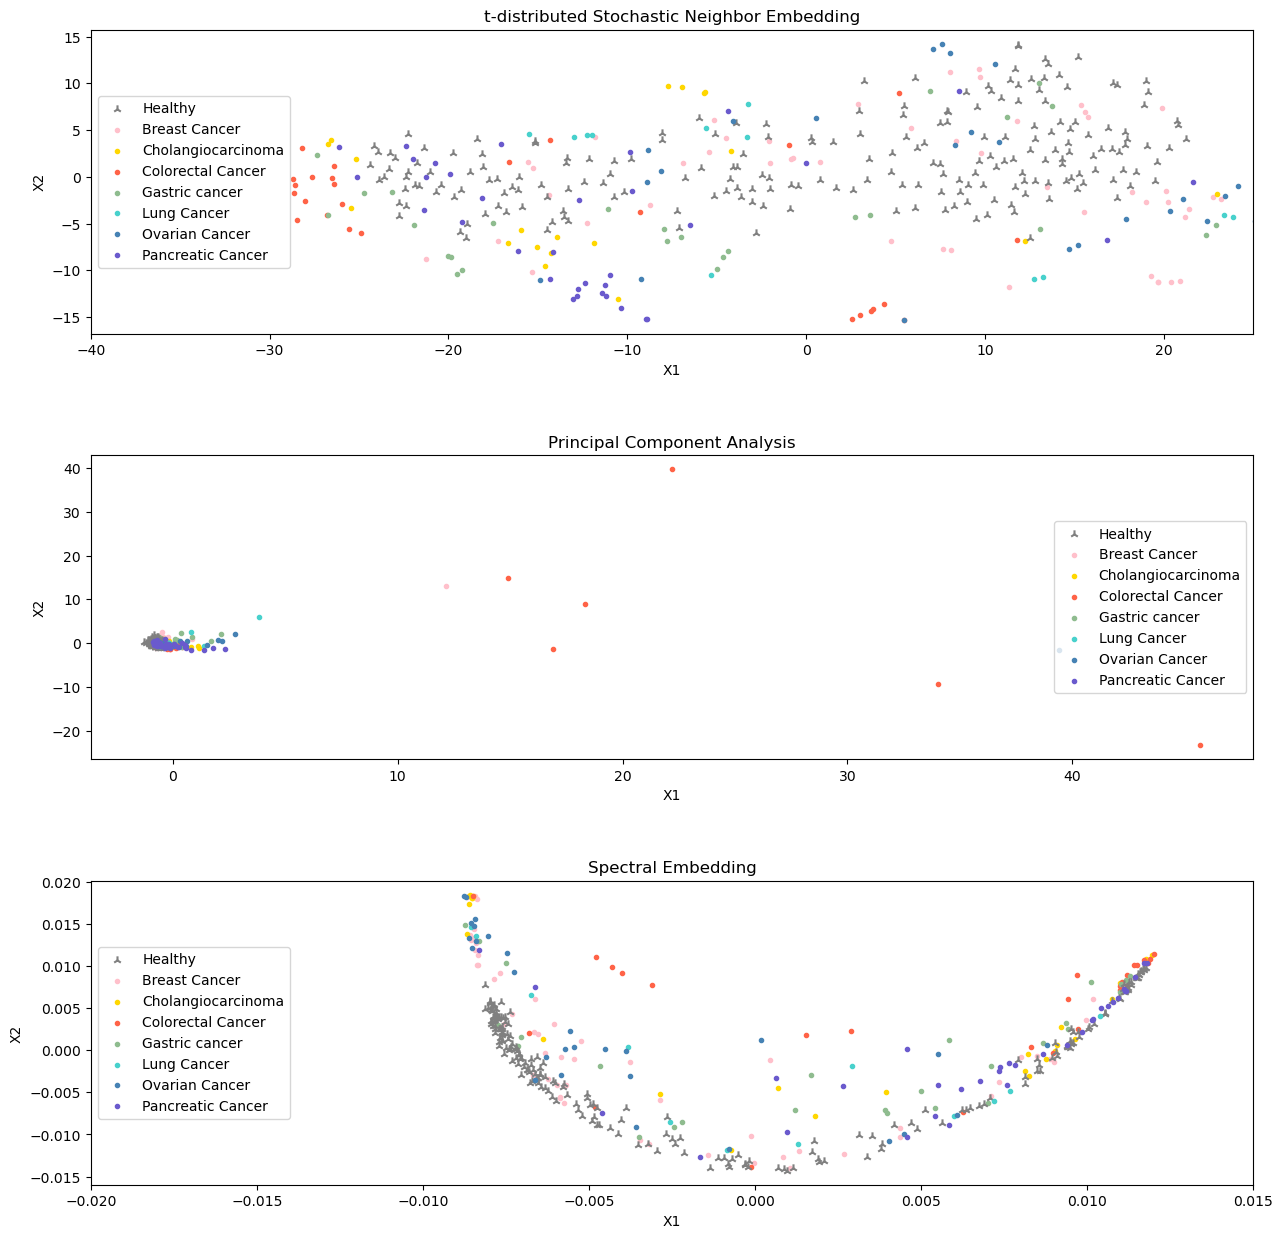

In [10]:
# dimention reduction
'''TSNE'''

x_new = TSNE(n_components=2).fit_transform(x)

fig = plt.figure(figsize=(15,15))
plt.subplot(3, 1, 1)

type0_x1 = []
type0_x2 = []
type1_x1 = []
type1_x2 = []
type2_x1 = []
type2_x2 = []
type3_x1 = []
type3_x2 = []
type4_x1 = []
type4_x2 = []
type5_x1 = []
type5_x2 = []
type6_x1 = []
type6_x2 = []
type7_x1 = []
type7_x2 = []

for i in range(len(y)):
    if y[i] == 0:  
        type0_x1.append(x_new[i][0])
        type0_x2.append(x_new[i][1])
        
    if y[i] == 1:  
        type1_x1.append(x_new[i][0])
        type1_x2.append(x_new[i][1])

    if y[i] == 2:  # Normal
        type2_x1.append(x_new[i][0])
        type2_x2.append(x_new[i][1])
        
    if y[i] == 3:  # Cancer
        type3_x1.append(x_new[i][0])
        type3_x2.append(x_new[i][1])

    if y[i] == 4:  # Cancer
        type4_x1.append(x_new[i][0])
        type4_x2.append(x_new[i][1])
        
    if y[i] == 5:  # Cancer
        type5_x1.append(x_new[i][0])
        type5_x2.append(x_new[i][1])
        
    if y[i] == 6:  # Cancer
        type6_x1.append(x_new[i][0])
        type6_x2.append(x_new[i][1])
        
    if y[i] == 7:  # Cancer
        type7_x1.append(x_new[i][0])
        type7_x2.append(x_new[i][1])
        
type0 = plt.scatter(type0_x1, type0_x2, c='pink', marker='.')
type1 = plt.scatter(type1_x1, type1_x2, c='gold', marker='.')
type2 = plt.scatter(type2_x1, type2_x2, c='tomato', marker='.')
type3 = plt.scatter(type3_x1, type3_x2, c='darkseagreen', marker='.')
type4 = plt.scatter(type4_x1, type4_x2, c='gray', marker='2')
type5 = plt.scatter(type5_x1, type5_x2, c='mediumturquoise', marker='.')
type6 = plt.scatter(type6_x1, type6_x2, c='steelblue', marker='.')
type7 = plt.scatter(type7_x1, type7_x2, c='slateblue', marker='.')
plt.legend((type4, type0, type1, type2, type3, type5, type6, type7), 
           (label_transform.inverse_transform([4])[0], 
            label_transform.inverse_transform([0])[0], 
            label_transform.inverse_transform([1])[0], 
            label_transform.inverse_transform([2])[0], 
            label_transform.inverse_transform([3])[0], 
            label_transform.inverse_transform([5])[0], 
            label_transform.inverse_transform([6])[0], 
            label_transform.inverse_transform([7])[0]), loc=6, fontsize = 10)
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('t-distributed Stochastic Neighbor Embedding')
# plt.legend((type1, type2), (u'Cancer', u'Normal'), loc=2)
plt.xlim(-40, 25)

'''PCA'''
from sklearn import preprocessing
from sklearn.decomposition import PCA
x_new = preprocessing.scale(x) 
x_new=PCA(n_components=2).fit_transform(x_new)
print(x_new.shape)
plt.subplot(3, 1, 2)
type0_x1 = []
type0_x2 = []
type1_x1 = []
type1_x2 = []
type2_x1 = []
type2_x2 = []
type3_x1 = []
type3_x2 = []
type4_x1 = []
type4_x2 = []
type5_x1 = []
type5_x2 = []
type6_x1 = []
type6_x2 = []
type7_x1 = []
type7_x2 = []

for i in range(len(y)):
    if y[i] == 0:  
        type0_x1.append(x_new[i][0])
        type0_x2.append(x_new[i][1])
        
    if y[i] == 1:  
        type1_x1.append(x_new[i][0])
        type1_x2.append(x_new[i][1])

    if y[i] == 2:  # Normal
        type2_x1.append(x_new[i][0])
        type2_x2.append(x_new[i][1])
        
    if y[i] == 3:  # Cancer
        type3_x1.append(x_new[i][0])
        type3_x2.append(x_new[i][1])

    if y[i] == 4:  # Cancer
        type4_x1.append(x_new[i][0])
        type4_x2.append(x_new[i][1])
        
    if y[i] == 5:  # Cancer
        type5_x1.append(x_new[i][0])
        type5_x2.append(x_new[i][1])
        
    if y[i] == 6:  # Cancer
        type6_x1.append(x_new[i][0])
        type6_x2.append(x_new[i][1])
        
    if y[i] == 7:  # Cancer
        type7_x1.append(x_new[i][0])
        type7_x2.append(x_new[i][1])
        
type0 = plt.scatter(type0_x1, type0_x2, c='pink', marker='.')
type1 = plt.scatter(type1_x1, type1_x2, c='gold', marker='.')
type2 = plt.scatter(type2_x1, type2_x2, c='tomato', marker='.')
type3 = plt.scatter(type3_x1, type3_x2, c='darkseagreen', marker='.')
type4 = plt.scatter(type4_x1, type4_x2, c='gray', marker='2')
type5 = plt.scatter(type5_x1, type5_x2, c='mediumturquoise', marker='.')
type6 = plt.scatter(type6_x1, type6_x2, c='steelblue', marker='.')
type7 = plt.scatter(type7_x1, type7_x2, c='slateblue', marker='.')
plt.legend((type4, type0, type1, type2, type3, type5, type6, type7), 
           (label_transform.inverse_transform([4])[0], 
            label_transform.inverse_transform([0])[0], 
            label_transform.inverse_transform([1])[0], 
            label_transform.inverse_transform([2])[0], 
            label_transform.inverse_transform([3])[0], 
            label_transform.inverse_transform([5])[0], 
            label_transform.inverse_transform([6])[0], 
            label_transform.inverse_transform([7])[0]), loc=7, fontsize = 10)
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Principal Component Analysis')


'''Spectral Embedding'''
from sklearn.manifold import SpectralEmbedding
x_new=SpectralEmbedding(n_components=2).fit_transform(x)
plt.subplot(3, 1, 3)
type0_x1 = []
type0_x2 = []
type1_x1 = []
type1_x2 = []
type2_x1 = []
type2_x2 = []
type3_x1 = []
type3_x2 = []
type4_x1 = []
type4_x2 = []
type5_x1 = []
type5_x2 = []
type6_x1 = []
type6_x2 = []
type7_x1 = []
type7_x2 = []

for i in range(len(y)):
    if y[i] == 0:  
        type0_x1.append(x_new[i][0])
        type0_x2.append(x_new[i][1])
        
    if y[i] == 1:  
        type1_x1.append(x_new[i][0])
        type1_x2.append(x_new[i][1])

    if y[i] == 2:  # Normal
        type2_x1.append(x_new[i][0])
        type2_x2.append(x_new[i][1])
        
    if y[i] == 3:  # Cancer
        type3_x1.append(x_new[i][0])
        type3_x2.append(x_new[i][1])

    if y[i] == 4:  # Cancer
        type4_x1.append(x_new[i][0])
        type4_x2.append(x_new[i][1])
        
    if y[i] == 5:  # Cancer
        type5_x1.append(x_new[i][0])
        type5_x2.append(x_new[i][1])
        
    if y[i] == 6:  # Cancer
        type6_x1.append(x_new[i][0])
        type6_x2.append(x_new[i][1])
        
    if y[i] == 7:  # Cancer
        type7_x1.append(x_new[i][0])
        type7_x2.append(x_new[i][1])
        
type0 = plt.scatter(type0_x1, type0_x2, c='pink', marker='.')
type1 = plt.scatter(type1_x1, type1_x2, c='gold', marker='.')
type2 = plt.scatter(type2_x1, type2_x2, c='tomato', marker='.')
type3 = plt.scatter(type3_x1, type3_x2, c='darkseagreen', marker='.')
type4 = plt.scatter(type4_x1, type4_x2, c='gray', marker='2')
type5 = plt.scatter(type5_x1, type5_x2, c='mediumturquoise', marker='.')
type6 = plt.scatter(type6_x1, type6_x2, c='steelblue', marker='.')
type7 = plt.scatter(type7_x1, type7_x2, c='slateblue', marker='.')
plt.legend((type4, type0, type1, type2, type3, type5, type6, type7), 
           (label_transform.inverse_transform([4])[0], 
            label_transform.inverse_transform([0])[0], 
            label_transform.inverse_transform([1])[0], 
            label_transform.inverse_transform([2])[0], 
            label_transform.inverse_transform([3])[0], 
            label_transform.inverse_transform([5])[0], 
            label_transform.inverse_transform([6])[0], 
            label_transform.inverse_transform([7])[0]), loc=6, fontsize = 10)
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Spectral Embedding')
plt.xlim(-0.020, 0.015)

plt.subplots_adjust(hspace =0.4) #adjust the space
plt.show()
# fig.savefig(r'CMP.eps',format='eps',bbox_inches = 'tight')